# Flower Classification

**Exploracion de datos y Preprocesamiento**

**Yalila Aljure Jimenez**

email: yalila.aljure@udea.edu.co

CC. 5288540



**IMPORTING LIBRARIES**

In [ ]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [ ]:
import keras
keras.__version__

'2.6.0'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import PIL
import pathlib
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib import pyplot as plt
import random
import math 
from sklearn.metrics import roc_curve, auc, multilabel_confusion_matrix, plot_confusion_matrix, roc_auc_score
from keras.layers import Conv2D, Dropout, MaxPooling2D, BatchNormalization, Activation, Flatten, Dense, InputLayer, Input, SeparableConv2D, ReLU, GlobalAvgPool2D,MaxPool2D,Add
from keras.models import Sequential, Model
from keras import regularizers
import mlflow
import mlflow.keras
import cv2

**LOAD DATA**

In [ ]:
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz

--2021-10-02 00:02:44--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.167.128, 74.125.71.128, 74.125.133.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M  43.5MB/s    in 5.0s    

2021-10-02 00:02:50 (43.5 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]



In [ ]:
# Unzipping Data
!gunzip flower_photos.tgz

In [ ]:
!tar -xvf flower_photos.tar

**Plotting Images**

In [ ]:
data_dir = pathlib.Path('flower_photos')
folder = list(data_dir.glob('*'))
images = list(data_dir.glob('*/*.jpg')) #list of all images (full path)

In [ ]:
len(images) # Number of images

3670

In [ ]:
fig = plt.figure(figsize=(20, 20))
iterable = np.array(random.sample(range(1, 3670), 54)) # Choosing 54 random images
for i in range(54):
    plt.subplot(9, 6, i+1)
    j = iterable[i]
    plt.title(str(images[j]).split('/')[-1], fontsize=10) # file name and disply as title
    plt.imshow(PIL.Image.open(images[j])) # Displaying Image
    ax = plt.axis("off")

Output hidden; open in https://colab.research.google.com to view.

**Parameters**

In [ ]:
image_size = 224 # Setting the size of the images
b_size = 32

**Imagen Preprocessing**

Data Augmantation

Original source is not partitioned. The test set will be fixed at 20% of the entire dataset. The rest of the dataset will be used for training (0.8) and validation (0.2).

In [ ]:
idg_flip = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
    validation_split = 0.2
)

In [ ]:
flower_gen_train = idg_flip.flow_from_directory(data_dir,
                                    target_size=(image_size, image_size),
                                    batch_size=b_size,
                                    subset='training',
                                    class_mode='categorical',
                                    shuffle=True,
                                    seed=123
                                    )

Found 2939 images belonging to 5 classes.


In [ ]:
flower_gen_test = idg_flip.flow_from_directory(data_dir,
                                    target_size=(image_size, image_size),
                                    batch_size=b_size,
                                    subset='validation',
                                    class_mode='categorical',
                                    shuffle=True,
                                    seed=123
                                    )

Found 731 images belonging to 5 classes.


**Xception**

In [ ]:
# creating the Conv-Batch Norm block

def conv_bn(x, filters, kernel_size, strides=1):
  x = Conv2D(filters=filters, 
               kernel_size = kernel_size, 
               strides=strides, 
               padding = 'same', 
               kernel_regularizer=regularizers.l1(0.01),
               use_bias = False)(x)
  x = BatchNormalization()(x)
  return x

In [ ]:
# creating separableConv-Batch Norm block

def sep_bn(x, filters, kernel_size, strides=1):
    x = SeparableConv2D(filters=filters, 
                        kernel_size = kernel_size, 
                        strides=strides, 
                        padding = 'same', 
                        kernel_regularizer=regularizers.l1(0.01),
                        use_bias = False)(x)
    x = BatchNormalization()(x)
    return x

In [ ]:
# entry flow

def entry_flow(x):
    
    x = conv_bn(x, filters =32, kernel_size =3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters =64, kernel_size =3, strides=1)
    tensor = ReLU()(x)
    
    x = sep_bn(tensor, filters = 128, kernel_size =3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 128, kernel_size =3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=128, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=256, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=728, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    return x

In [ ]:
# middle flow

def middle_flow(tensor):
    
    for _ in range(8):
        x = ReLU()(tensor)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        tensor = Add()([tensor,x])
        
    return tensor

In [ ]:
# exit flow

def exit_flow(tensor):
    
    
    x = ReLU()(tensor)
   
    x = sep_bn(x, filters = 728,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 1024,  kernel_size=3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding ='same')(x)
    tensor = conv_bn(tensor, filters =1024, kernel_size=1, strides =2)
    x = Add()([tensor,x])
    
    x = sep_bn(x, filters = 1536,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 2048,  kernel_size=3)
    x = GlobalAvgPool2D()(x)
    
    

    x = Dense (units = 5, activation = 'softmax')(x)
    
    return x

In [ ]:
input = Input(shape = (image_size,image_size,3))
x = entry_flow(input)
x = middle_flow(x)
output = exit_flow(x)

model = Model (inputs=input, outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 112, 112, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy','Precision','Recall'])

In [ ]:
Result = model.fit(flower_gen_train, validation_data=flower_gen_test
                   , epochs=30, verbose=1, shuffle=True)

2021/10/02 00:03:27 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f83d71c7ee8742368e6abbd3be0d48bb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


Epoch 1/30
92/92 [==============================] - 212s 2s/step - loss: 285.3033 - accuracy: 0.5322 - precision: 0.6708 - recall: 0.3300 - val_loss: 244.0495 - val_accuracy: 0.2175 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
92/92 [==============================] - 168s 2s/step - loss: 207.1396 - accuracy: 0.6053 - precision: 0.7064 - recall: 0.4634 - val_loss: 172.7742 - val_accuracy: 0.2175 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/30
92/92 [==============================] - 167s 2s/step - loss: 142.3677 - accuracy: 0.6274 - precision: 0.7162 - recall: 0.5134 - val_loss: 114.7597 - val_accuracy: 0.2449 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/30
92/92 [==============================] - 167s 2s/step - loss: 90.8277 - accuracy: 0.6492 - precision: 0.7331 - recall: 0.5356 - val_loss: 69.9968 - val_accuracy: 0.2449 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/30
92/92 [==============================] - 167s 2s/st

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



In [ ]:
mpl.rcParams.update({'font.size': 10, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

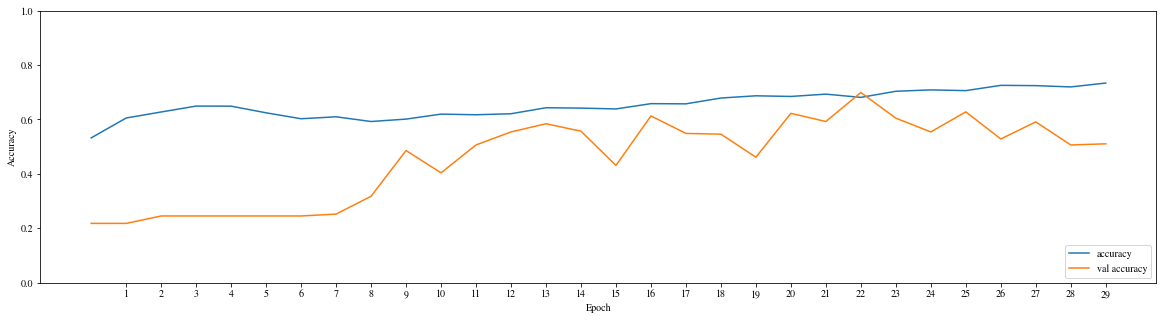

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(Result.history['accuracy'], label='accuracy')
plt.plot(Result.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(range(1,30)))
plt.ylim([0, 1])
plt.legend(loc='lower right')


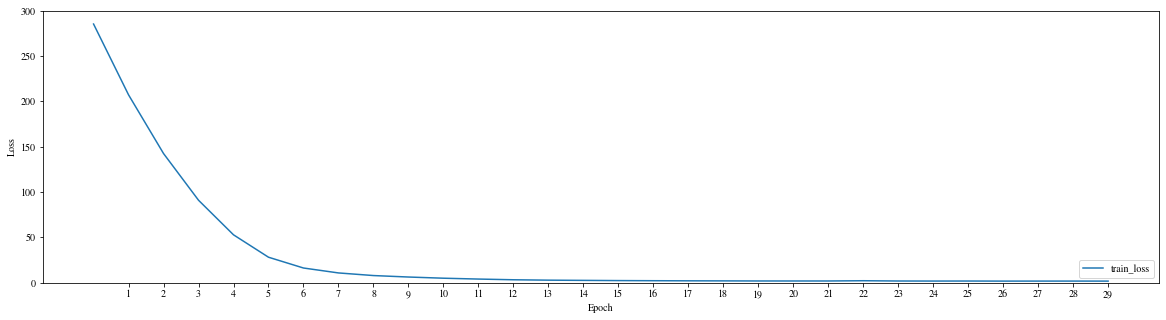

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(Result.history['loss'], label='train_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(list(range(1,30)))
plt.ylim([0, 300])
plt.legend(loc='lower right')

**Plot Evaluation**

In [ ]:
model.save("07_model.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



In [ ]:
def plot_example(X, y, y_pred=None):
# Create figure with 3 x 3 sub-plots.
  fig, axes = plt.subplots(3, 6)
  fig.set_size_inches(18,10)
  fig.subplots_adjust(hspace=0.3, wspace=0.3)
  X, y = X[:18, ..., 0], y[:18]
  for i, ax in enumerate(axes.flat):
    # Plot image.
    ax.imshow(X[i], alpha = 1)
    # Show true and predicted classes.
    if y_pred is None:
      xlabel = "True: {0}".format(y[i])
    else:
      xlabel = "True: {0}, Pred: {1}".format(y[i], y_pred[i])
    # Show the classes as the label on the x-axis.
    ax.set_xlabel(xlabel)
    # Remove ticks from the plot.
    ax.set_xticks([])
    ax.set_yticks([])
    # Ensure the plot is shown correctly with multiple plots in a single Notebook cell.
  plt.show()

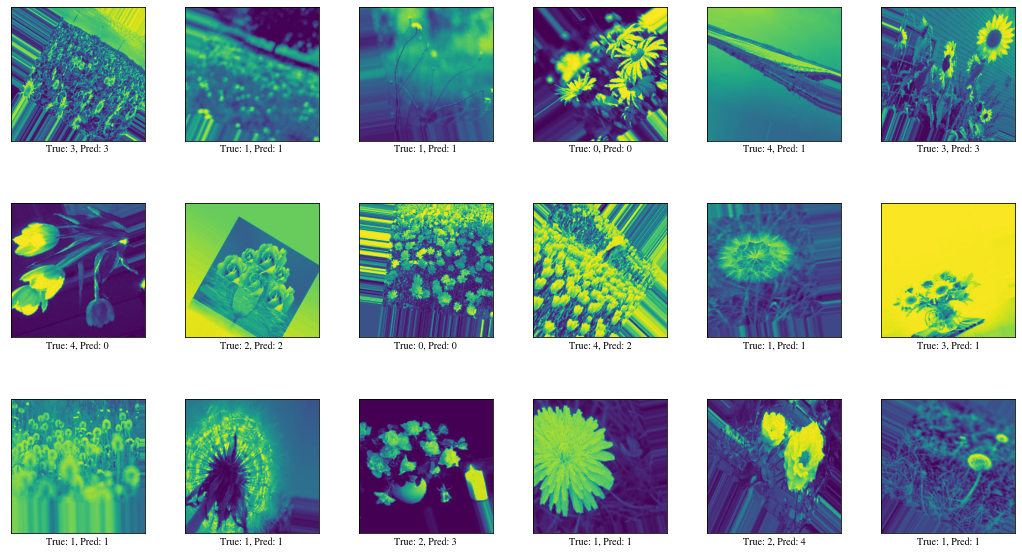

In [ ]:
model = tf.keras.models.load_model('07_model.h5')
#%matplotlib inline
# Make prediction
predictions = model.predict(x_test)
# retrieve prediction indices
pred_y = np.argmax(predictions, axis=1)
# Plot some examples with model predictions
plot_example(x_test, y_test, y_pred)